# Deep Dive into Neural Network Architectures

In this lecture, we'll explore different convolutional neural networks that have revolutionized various fields, including image recognition, object detection and semantic segmentation. Get ready for a hands-on workshop experience with PyTorch!

**Prerequisites:** Basic understanding of neural networks, activation functions, backpropagation, and training.


## Convolutional Neural Networks (CNNs)

We learned about multi-layer perceptrons in the previous lab. A classic application for neural networks is image recognition. Consider, for simplicity's sake, an image which is a matrix of pixels. In a color image, each pixel might be represented by 3 RGB values. In greyscale, we can use a single integer which indicates how dark a pixel is. We can even flatten a 3x3 matrix into a 9x1 vector.

![rgb_pixels](images/4x4x3-rgb-image.png)  ![greyscale_pixels](images/greyscale_flattening.png)

We could try to provide the vector of pixel values as input to a multi-layer perceptron and ask it to classify the image, but how well do you think it could perform?

Take these very, very crude smiley faces and an X as a first example:

![Smile Faces](images/smiles_x.jpg)

If we use white = 0 and black = 1 and flatten the 7x7 grid to a vector with length 49, we end up with something like this:
`[0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0]`

With many many more examples, we might be able to discern some patterns, but seemingly there's not much more in common among the smiles than there is with the X. Now also consider that some smiley faces might be tipped on their sides, like this `:)`, oriented differently, or moved within the 7x7 grid we have chosen. Naively flattening the grid into a vector of numbers probably won't yield the results we're hoping for.

Enter Convolutional Neural Networks. CNNs are designed for processing grid-like data, such as images. They excel at capturing spatial hierarchies and local patterns, making them ideal for tasks like image recognition, object detection, and image segmentation.

![Convolutional Neural Network](images/cnn_sequence.png)

### Key Components

*   **Convolutional Layers:** Convolutional layers are the fundamental building blocks of CNNs that perform feature extraction through:
    * Kernels/Filters: These are small matrices (typically 3×3, 5×5, or 7×7) that slide across the input image to compute element-wise multiplications followed by summation. Each kernel detects specific patterns - early layers detect simple features like edges and gradients, while deeper layers identify complex patterns like textures and objects.
    * Stride: Controls how many pixels the filter moves at each step. Larger strides reduce spatial dimensions more aggressively.
    * Padding: Adding extra pixels (usually zeros) around the input to control output dimensions. "Same" padding preserves spatial dimensions, while "valid" padding reduces them.
    * Channel Dimensionality: Each convolutional layer typically increases the number of channels (feature maps) while decreasing spatial dimensions, creating a hierarchical feature representation.

![Convolutional Kernel](images/convolved-feature.gif)

*   **Pooling Layers:** Pooling layers reduce computational complexity and provide spatial invariance through:
    * Max Pooling: Selects the maximum value from each patch, effectively preserving the strongest features while discarding weaker activations.
    * Average Pooling: Calculates the average value of each patch, which can retain more background information.
    * Global Pooling: Reduces each feature map to a single value, often used before fully connected layers to dramatically reduce parameters.
    * Benefits: Pooling makes the network more robust to small translations in the input, reduces overfitting by providing a form of regularization, and decreases computational burden.

![Max and Average Pooling](images/max_v_average_pooling.png)

*   **Activation Functions:**  Activation functions introduce non-linearity, enabling networks to learn complex relationships:
    * ReLU (Rectified Linear Unit): f(x) = max(0,x). The most common activation in CNNs due to its computational efficiency and effectiveness in addressing the vanishing gradient problem.
    * Leaky ReLU: Modifies ReLU to allow small negative values, preventing "dead neurons."
    * ELU (Exponential Linear Unit): Provides smoother gradients for negative inputs while maintaining ReLU benefits.
    * Sigmoid/Tanh: Historically used but less common in hidden layers of modern CNNs due to vanishing gradient issues; sigmoid is still used for binary classification outputs.

*   **Fully Connected Layers:** These layers serve as the "decision-making" component of CNNs:
    * Flattening: Before fully connected layers, the 3D feature maps must be flattened into a 1D vector.
    * Dense Connections: Each neuron connects to every neuron in the previous layer, enabling global reasoning about features across the entire image.
    * Classification Head: Typically includes one or more fully connected layers followed by a softmax activation (for multi-class classification) or sigmoid (for binary classification).
    * Parameter Efficiency: These layers often contain the majority of the network's parameters, making them computationally expensive and prone to overfitting without proper regularization.

### References:
* Image source and also excellent explanation: [Saturn Cloud's Guide to CNNs](https://saturncloud.io/blog/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way/).
* [DataCamp video on CNNs ~5 minutes](https://campus.datacamp.com/courses/intermediate-deep-learning-with-pytorch/images-convolutional-neural-networks?ex=5)

### Practical Example: Image Classification with CNNs

Let's build a CNN to classify images from the CIFAR-10 dataset using PyTorch. The [CIFAR-10 dataset](https://www.kaggle.com/c/cifar-10/) is a subset of a much larger dataset, containing 60000 32x32 color images containing one of ten object classes: {airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck}


In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# convert images to PyTorch tensors, standardize RGB channels to mean = 0.5 and std = 0.5
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset, containing 60k 32x32 color images
# create shuffled training batches of 64 images each
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


class CNN(nn.Module):
    # CNN architecture
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)         # first convolutional layer: 3 input channels (RGB), 6 output channels, 5x5 kernel/filter
        self.pool = nn.MaxPool2d(2, 2)          # 2x2 max pooling layers with stride 2 (cuts spatial dimensions in half)
        self.conv2 = nn.Conv2d(6, 16, 5)        # second convolutional layer: 6 input channels, 16 output channels, 5x5 kernel/filter
        self.fc1 = nn.Linear(16 * 5 * 5, 120)   # first fully connected layer, 16 output * 5 pixels * 5 pixels to 120 neurons
        self.fc2 = nn.Linear(120, 84)           # second fully connected layer, 120 neurons to 84 neurons
        self.fc3 = nn.Linear(84, 10)            # third fully connected layer, 84 neurons to 10 neurons

    # forward pass
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) # first conv layer -> ReLU activation -> max pooling
        x = self.pool(torch.relu(self.conv2(x))) # second conv layer -> ReLU activation -> max pooling
        x = x.view(-1, 16 * 5 * 5)               # flattening 3D feature maps (16*5*5) into 1D vector
        x = torch.relu(self.fc1(x))              # three fully connected layers with ReLU between them
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x                                # output is 10 logits, one per class

# Initialize the model, optimizer, and loss function
model = CNN()
model.to(device)
optimizer = optim.Adam(model.parameters())      # Adam optimizer adapts learning rate for each parameter
criterion = nn.CrossEntropyLoss()               # CrossEntropyLoss combines softmax activation and negative log-likelihood loss

# Training loop (simplified for brevity)
for epoch in range(2):  # Adjust the number of epochs as needed
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device) # move tensors to GPU if possible
        optimizer.zero_grad()                   # zeros the gradients to prevent accumulation
        outputs = model(inputs)                 # forward pass to get predictions
        loss = criterion(outputs, labels)       # calculates loss between predictions and true class
        loss.backward()                         # back propagates to compute gradients
        optimizer.step()                        # updates weights using the optimizer
        if i % 100 == 0:
            print(f"Epoch: {epoch + 1}, Batch: {i}, Loss: {loss.item()}")       # prints loss every 100 batches to show changes

print('Finished Training')


Using device: cuda:0


c:\Kenric\AA\course-material-2526\venv\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Epoch: 1, Batch: 0, Loss: 2.2965965270996094
Epoch: 1, Batch: 100, Loss: 1.8378431797027588
Epoch: 1, Batch: 200, Loss: 1.6127463579177856
Epoch: 1, Batch: 300, Loss: 1.482147455215454
Epoch: 1, Batch: 400, Loss: 1.594329595565796
Epoch: 1, Batch: 500, Loss: 1.4900537729263306
Epoch: 1, Batch: 600, Loss: 1.5693215131759644
Epoch: 1, Batch: 700, Loss: 1.3328845500946045
Epoch: 2, Batch: 0, Loss: 1.4680662155151367
Epoch: 2, Batch: 100, Loss: 1.5837223529815674
Epoch: 2, Batch: 200, Loss: 1.2982006072998047
Epoch: 2, Batch: 300, Loss: 1.846808671951294
Epoch: 2, Batch: 400, Loss: 1.4796382188796997
Epoch: 2, Batch: 500, Loss: 1.3314595222473145
Epoch: 2, Batch: 600, Loss: 1.4075884819030762
Epoch: 2, Batch: 700, Loss: 1.1527503728866577
Finished Training


### How can we interpret this output?

#### Training Progression
The output shows loss values at different points during training:
* Format: Epoch: [epoch_number], Batch: [batch_number], Loss: [loss_value]
* Loss is printed every 100 batches (as specified in the code with if i % 100 == 0)

#### Key Observations:
1. Loss Trend: The loss starts at around 2.31 in the first epoch and generally decreases over time, ending at about 1.44 by the end of the second epoch.
2. Learning Progress:
    * Note: each time this is run, the batches will be randomized, resulting in different output.
    * First epoch: Loss decreases from 2.31 → ~1.31 (approximately 40% reduction)
    * Second epoch: Loss fluctuates but continues the downward trend from 1.44 → ~1.32
3. Fluctuations: Notice that the loss doesn't decrease monotonically. There are ups and downs (e.g., 1.44 → 1.37 → 1.49). This is normal in mini-batch training, as each batch contains different images with varying difficulty.
4. Training Speed: Each epoch processes about 700+ batches with the batch size of 64. Since CIFAR-10 has 50,000 training images, this aligns with approximately 45,000-50,000 images per epoch.

#### Interpretation:
* Model is Learning: The consistent downward trend in loss indicates your model is learning useful patterns from the data.
* Early Training Phase: With only 2 epochs, your model is still in the early learning phase. Modern CNN training typically involves 50-200 epochs for CIFAR-10.
* Room for Improvement: The final loss value of around 1.32 is still relatively high for a converged model on CIFAR-10. Well-tuned models can achieve loss values below 0.5.
* Learning Rate: The gradual decrease in loss suggests your learning rate is reasonable (not too high causing divergence, not too low causing stagnation).

### Think about what the next steps should be...

### Evaluating Your Model

You'll remember the Confusion Matrix from Data Analytics and Machine Learning. This can help us visualize the performance of a classification model.

=== Overall Metrics ===
Accuracy:                 0.5286
Balanced Accuracy:        0.5286
Precision (micro):        0.5286
Recall (micro):           0.5286
F1-score (micro):         0.5286
Precision (macro):        0.5330
Recall (macro):           0.5286
F1-score (macro):         0.5176
Precision (weighted):     0.5330
Recall (weighted):        0.5286
F1-score (weighted):      0.5176

=== Per-class Metrics ===
 0   airplane | Prec: 0.5854  Rec: 0.6030  F1: 0.5941  Support: 1000
 1 automobile | Prec: 0.6884  Rec: 0.5590  F1: 0.6170  Support: 1000
 2       bird | Prec: 0.4101  Rec: 0.4220  F1: 0.4160  Support: 1000
 3        cat | Prec: 0.4035  Rec: 0.3260  F1: 0.3606  Support: 1000
 4       deer | Prec: 0.4972  Rec: 0.3550  F1: 0.4142  Support: 1000
 5        dog | Prec: 0.5737  Rec: 0.2490  F1: 0.3473  Support: 1000
 6       frog | Prec: 0.5683  Rec: 0.6950  F1: 0.6253  Support: 1000
 7      horse | Prec: 0.4881  Rec: 0.7200  F1: 0.5818  Support: 1000
 8       ship | Prec: 0.6299  Rec:

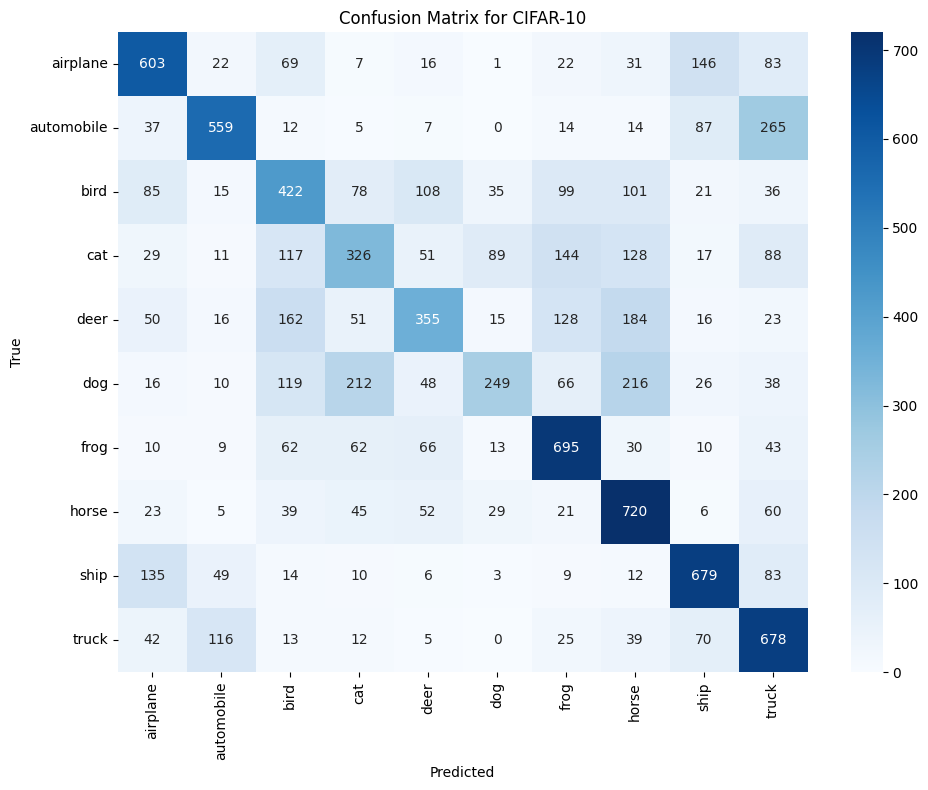

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Gather predictions and true labels
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in testloader:
        # Move input data to GPU
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Move predictions and labels back to CPU for numpy conversion
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    balanced_accuracy_score
)
import numpy as np

# --- Overall accuracy ---
accuracy = accuracy_score(all_labels, all_preds)
balanced_acc = balanced_accuracy_score(all_labels, all_preds)  # accounts for class imbalance

# --- Per-class precision, recall, F1, support ---
# averages: 'macro' (unweighted mean), 'weighted' (weighted by support), 'micro' (global)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='macro', zero_division=0
)
prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='weighted', zero_division=0
)
prec_micro, rec_micro, f1_micro, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='micro', zero_division=0
)

# Per-class metrics (arrays aligned with label indices 0..9 for CIFAR-10)
prec_cls, rec_cls, f1_cls, support = precision_recall_fscore_support(
    all_labels, all_preds, average=None, zero_division=0
)

print("=== Overall Metrics ===")
print(f"Accuracy:                 {accuracy:.4f}")
print(f"Balanced Accuracy:        {balanced_acc:.4f}")
print(f"Precision (micro):        {prec_micro:.4f}")
print(f"Recall (micro):           {rec_micro:.4f}")
print(f"F1-score (micro):         {f1_micro:.4f}")
print(f"Precision (macro):        {prec_macro:.4f}")
print(f"Recall (macro):           {rec_macro:.4f}")
print(f"F1-score (macro):         {f1_macro:.4f}")
print(f"Precision (weighted):     {prec_weighted:.4f}")
print(f"Recall (weighted):        {rec_weighted:.4f}")
print(f"F1-score (weighted):      {f1_weighted:.4f}")
print()

print("=== Per-class Metrics ===")
for i, name in enumerate(class_names):
    print(f"{i:2d} {name:>10s} | "
          f"Prec: {prec_cls[i]:.4f}  Rec: {rec_cls[i]:.4f}  F1: {f1_cls[i]:.4f}  Support: {support[i]}")

print("\n=== Full Classification Report ===")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

# Plot with labels
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for CIFAR-10')
plt.tight_layout()
plt.show()

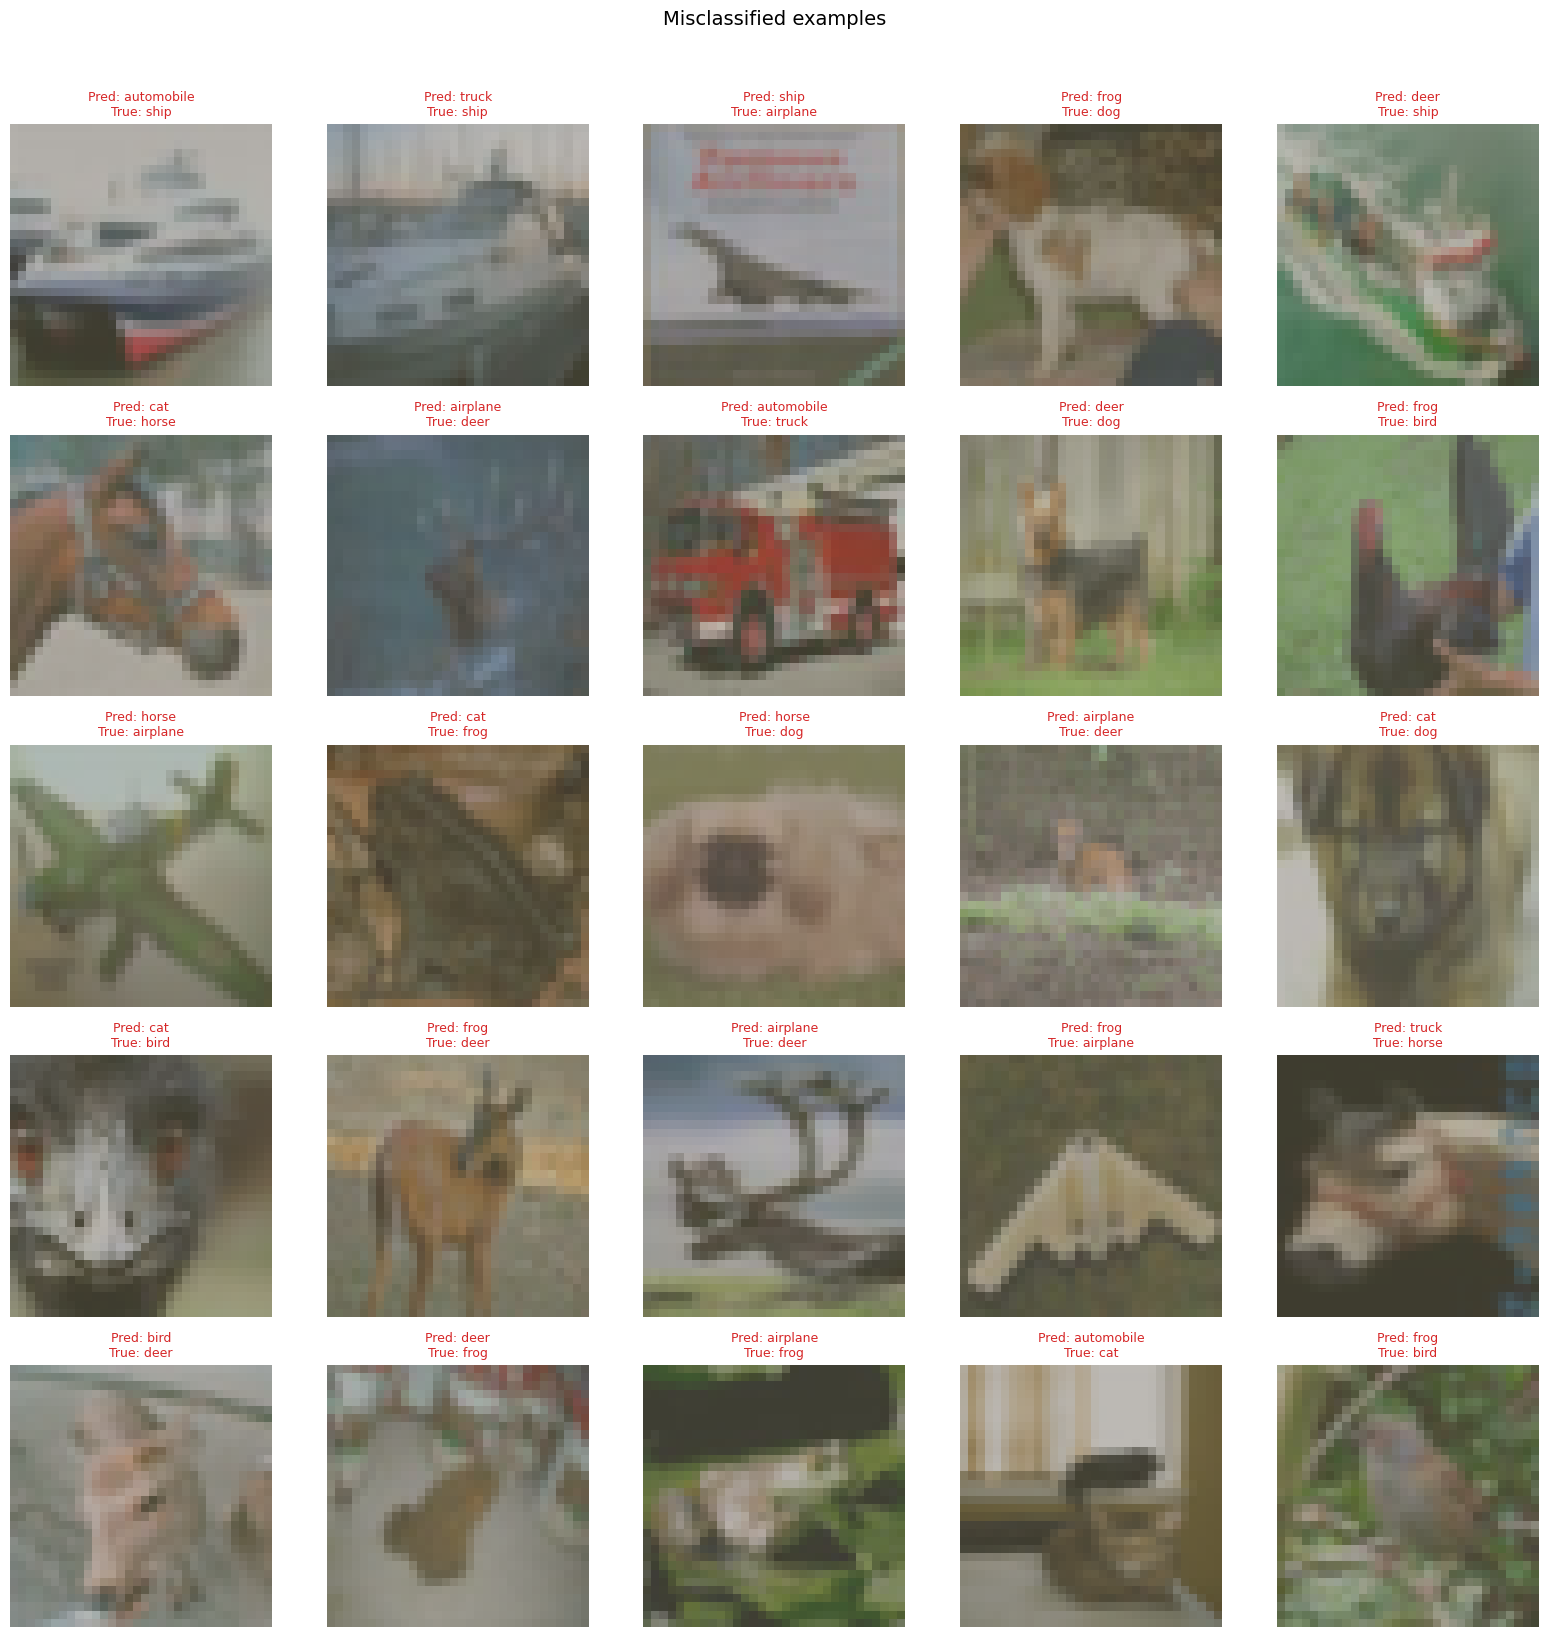

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Use CIFAR-10 normalization values if you normalized your dataset that way.
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

def unnormalize(img_t, mean=CIFAR10_MEAN, std=CIFAR10_STD):
    """
    img_t: Tensor of shape (C, H, W), normalized
    returns: numpy array (H, W, C) in [0,1]
    """
    img = img_t.detach().cpu().float().clone()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    img = img.clamp(0, 1).permute(1, 2, 0).numpy()
    return img

def show_misclassified(model, dataloader, device, class_names, max_images=25, cols=5):
    model.eval()
    wrong_images = []
    wrong_preds = []
    wrong_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            mis_idx = (preds != labels).nonzero(as_tuple=False).squeeze(-1)
            if mis_idx.numel() > 0:
                wrong_images.extend(images[mis_idx].cpu())
                wrong_preds.extend(preds[mis_idx].cpu().tolist())
                wrong_labels.extend(labels[mis_idx].cpu().tolist())

            if len(wrong_images) >= max_images:
                break

    n = min(len(wrong_images), max_images)
    if n == 0:
        print("No misclassified images found 🎉")
        return

    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(3.2*cols, 3.2*rows))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        img = unnormalize(wrong_images[i])
        plt.imshow(img)
        true_lbl = class_names[wrong_labels[i]]
        pred_lbl = class_names[wrong_preds[i]]
        color = 'tab:red' if wrong_preds[i] != wrong_labels[i] else 'tab:green'
        plt.title(f"Pred: {pred_lbl}\nTrue: {true_lbl}", fontsize=9, color=color)
        plt.axis('off')
    plt.suptitle("Misclassified examples", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

# ---- Call it after your evaluation loop (you already have model, device, testloader, class_names) ----
show_misclassified(model, testloader, device, class_names, max_images=25, cols=5)

CIFAR‑10 images look pixelated because the entire dataset consists of very small 32×32‑pixel images. This resolution is extremely low by modern standards, so when you display them on your screen—especially when Matplotlib scales them up to several hundred pixels—they naturally appear blocky and blurry. Nothing is wrong with your GPU, model, or plotting code. The dataset was intentionally created at this tiny size to make training fast and computationally cheap for research. Since libraries like Matplotlib must enlarge the 32×32 image to show it, the result looks pixelated regardless of how you trained your model. This is normal and expected behavior. If you want clearer images, you need a dataset with higher resolution such as STL‑10 (96×96), Tiny ImageNet (64×64), or ImageNet (224×224 crops).

#### What can you say about the CNN's performance? What does it do well? Where does it make mistakes?

### Additional Exercise

Look up some other models trained on CIFAR-10 and try to outperform this model.

## COCO Object Detection + COCOeval + Visualization 

This script implements a full “real-world” object detection workflow on the COCO validation set using a pretrained Faster R-CNN model from torchvision. The goal is to (1) run inference on COCO images, (2) collect the predicted bounding boxes and class labels, (3) evaluate those predictions using the official COCO evaluation tools (mAP, AR, etc.), and (4) visualize predictions by drawing bounding boxes on an image. In other words, it demonstrates the complete path from a dataset to measurable performance metrics and interpretable output images—exactly what students need for a practical computer vision project.

The code starts by importing PyTorch, Torchvision, and relevant utilities such as DataLoader and Subset. It then selects the computation device: GPU if available, otherwise CPU. Next, it defines a simple transformation pipeline consisting only of ToTensor(), which converts each COCO image from a PIL image into a PyTorch tensor with values scaled into [0, 1]. This is the minimal required transformation for running inference on pretrained torchvision detection models. The script then points to the local COCO validation image directory and the COCO annotation JSON file. At this stage, the dataset is created (in your case through a CocoDataset wrapper), and then reduced to the first 200 samples using Subset to make the exercise fast enough for classroom use.

Because object detection images can contain different numbers of objects, the batches cannot be stacked into a single tensor automatically like in classification. That’s why the script defines a custom collate_fn, which keeps images as a list rather than attempting to combine them into a fixed-size tensor. The DataLoader then produces batches of 16 images as lists, which is exactly what fasterrcnn_resnet50_fpn expects. After that, the pretrained Faster R-CNN model is loaded with COCO-trained weights (weights="DEFAULT"), moved to the chosen device, and set to evaluation mode (model.eval()). Evaluation mode is important because it disables training-specific behavior like dropout and ensures consistent results during inference.

The next part performs inference on the validation subset. The script iterates through the validation loader without computing gradients (torch.no_grad()), which makes inference faster and reduces memory usage. For each batch, images are moved to the GPU/CPU, passed through the model, and the model returns predictions for each image in the batch. Each prediction contains bounding boxes (boxes), confidence scores (scores), and predicted class IDs (labels). These outputs are moved back to CPU and stored in all_predictions. This creates a complete collection of model predictions for the chosen subset of COCO images, which will be used for evaluation.

After inference is complete, the code switches into COCO-style evaluation using pycocotools. It loads the ground-truth COCO annotations using the COCO class, then creates a results list by converting model predictions into the exact JSON format expected by COCOeval. A key detail here is the conversion of bounding boxes: Torchvision returns boxes as [xmin, ymin, xmax, ymax], but COCO evaluation requires [xmin, ymin, width, height]. The code computes width and height from the predicted corners, filters predictions using a confidence threshold (score > 0.5), and writes them into a coco_results.json file. That JSON file is then loaded as detection results (coco_dt) and evaluated against the ground truth (coco_gt) using COCOeval. The evaluation process runs in three steps—evaluate(), accumulate(), and summarize()—and prints standard COCO metrics such as mAP at different IoU thresholds.

Finally, the script produces a visualization that students can immediately interpret. It grabs a new batch from the validation loader, selects a random image, and runs the detector again on that single image. It then converts the image tensor back into a NumPy array for plotting, and draws predicted bounding boxes on top of it using matplotlib rectangles. Boxes are filtered again by confidence (score > 0.5) so the image is not cluttered by very low-confidence detections. The resulting figure is saved to disk as coco_prediction.png and displayed. This step gives students the “instant gratification” aspect—seeing bounding boxes appear—while also connecting it to the quantitative COCO evaluation metrics earlier in the script.

### First steps

If you cannot download the data automatically, then you should do it manually and make a folder structure like:

-> data -> coco -> train

                -> val

                -> annotations -> train_instances

                               -> val_instances
                            
This can take 20-30 minutes and up to 20GB

In [ ]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.datasets import CocoDetection
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Transform
# -------------------------
transform = transforms.Compose([
    transforms.ToTensor()
])

# -------------------------
# Load COCO Validation Set , THIS IS YOUR PERSONAL PATH
# -------------------------
val_root = "C:\Kenric\AA\course-material-2526\data\coco//val2017//val2017"
val_ann  = "C:\Kenric\AA\course-material-2526\data\coco//annotations//instances_val2017.json"

val_dataset   = CocoDataset(val_root, val_ann)

# Use subset for faster evaluation, take a batch of 4 for quick results
val_dataset = Subset(val_dataset, range(200))

def collate_fn(batch):
    return tuple(zip(*batch))

val_loader = DataLoader(val_dataset, batch_size=16, collate_fn=collate_fn)

# -------------------------
# Load Pretrained Model
# -------------------------
model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
model.to(device)
model.eval()

print("Model loaded and ready.")


loading annotations into memory...
Done (t=0.27s)
creating index...
index created!
Model loaded and ready.


In [74]:
all_predictions = []

with torch.no_grad():
    for images, _ in val_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for output in outputs:
            all_predictions.append({
                "boxes": output["boxes"].cpu(),
                "scores": output["scores"].cpu(),
                "labels": output["labels"].cpu()
            })

print("Inference complete.")


Inference complete.


In [75]:
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO
import json
import numpy as np

# Load ground truth
coco_gt = COCO(val_ann)

results = []

image_ids = coco_gt.getImgIds()[:200]

for img_id, prediction in zip(image_ids, all_predictions):

    boxes = prediction["boxes"]
    scores = prediction["scores"]
    labels = prediction["labels"]

    for box, score, label in zip(boxes, scores, labels):

        if score > 0.5:
            xmin, ymin, xmax, ymax = box.numpy()
            width = xmax - xmin
            height = ymax - ymin

            results.append({
                "image_id": img_id,
                "category_id": int(label),
                "bbox": [float(xmin), float(ymin), float(width), float(height)],
                "score": float(score)
            })

# Save predictions
with open("coco_results.json", "w") as f:
    json.dump(results, f)

# Load predictions
coco_dt = coco_gt.loadRes("coco_results.json")

# Evaluate
coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
coco_eval.params.imgIds = image_ids

coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.35s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.14s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

### What Does IoU=0.50:0.95 Mean?

IoU = Intersection over Union.
It measures how much the predicted bounding box overlaps with the ground truth box.
COCO does something strict:

It averages AP over 10 IoU thresholds:

0.50, 0.55, 0.60, ..., 0.95


That’s very demanding.
Even strong models usually get:

~0.35–0.45 mAP on COCO

0.50 is already good

0.60+ is strong

### What AP=0.000 Literally Means

it means that, under COCO’s official evaluation protocol, the model produced no detections that were counted as correct matches across the IoU thresholds from 0.50 to 0.95. In practice, this almost never means the pretrained model is poor. Instead, it almost always indicates a pipeline or alignment issue in the evaluation setup.

The most common cause is a category ID mismatch. COCO uses specific category IDs that must exactly match those in the annotation file. If the predicted category_id values do not correspond exactly to COCO’s ground truth IDs, even perfectly placed bounding boxes will be treated as incorrect class predictions. As a result, every detection becomes a false positive and AP becomes zero.

Another very common cause is an image ID mismatch. COCOeval expects each prediction to be associated with the exact image_id from the annotation file. If predictions are paired with the wrong image IDs—often due to using Subset, slicing image IDs manually, or relying on a different ordering between dataset iteration and getImgIds()—then predictions are evaluated against the wrong ground-truth image. Even good detections will fail to match, leading again to AP = 0.000.

A third reason is over-filtering predictions. If you apply a confidence threshold such as score > 0.5, and the model’s predicted scores are mostly below that threshold, you may accidentally discard all detections. If no detections are passed to COCOeval, the result is automatically zero AP.

It can also happen if bounding box formatting is incorrect. COCO requires boxes in [xmin, ymin, width, height] format, while torchvision outputs [xmin, ymin, xmax, ymax]. If the conversion is wrong, for example width or height miscalculated, the IoU with ground truth boxes becomes zero, and detections are never counted as true positives.

Finally, using only a small subset of images can amplify any of these issues. If the subset selection and image ID extraction are not perfectly aligned, the evaluation silently fails without throwing an error, and AP remains zero.

In short, AP = 0.000 almost always means that the evaluator could not match any predicted bounding box to a correct ground-truth object under COCO’s strict IoU and category rules, not that the model itself is incapable of detecting objects.

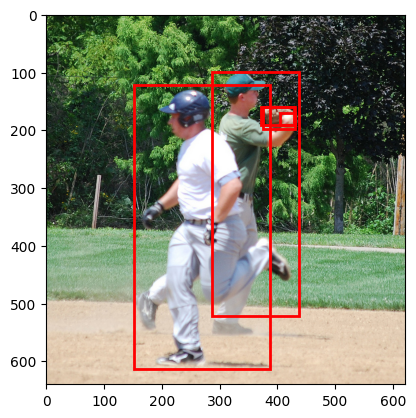

Saved visualization as coco_prediction.png


In [90]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

idx = random.randint(0, len(images) - 1)

images, _ = next(iter(val_loader))
image = images[idx].to(device)

with torch.no_grad():
    prediction = model([image])[0]

image = image.cpu().permute(1, 2, 0).numpy()

fig, ax = plt.subplots(1)
ax.imshow(image)

for box, score in zip(prediction["boxes"], prediction["scores"]):
    if score > 0.5:
        xmin, ymin, xmax, ymax = box.cpu()
        rect = patches.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            linewidth=2,
            edgecolor="red",
            facecolor="none"
        )
        ax.add_patch(rect)

plt.savefig("coco_prediction.png")
plt.show()

print("Saved visualization as coco_prediction.png")

## Mask R‑CNN Segmentation Exercise

Loading the Pretrained Model
We begin by loading a Mask R‑CNN model trained on the COCO dataset. TorchVision provides this model with pretrained weights and accompanying metadata, including the list of COCO category names. By using the metadata that comes with the COCO-trained weights, we ensure that the class labels predicted by the model match the correct category list. This prevents the common error of mismatched indices when using custom category lists.
The model is set to evaluation mode using model.eval(). This disables training-specific behaviors like dropout and gradient computation, ensuring faster inference and consistent results. Since the model has already learned rich visual features from the COCO dataset’s 118,000 annotated images, it can detect a wide variety of everyday objects such as people, animals, vehicles, tools, and more.

Preprocessing and Running Inference
An input image is first transformed into a tensor using TorchVision’s standard preprocessing. Mask R‑CNN expects images in the form of PyTorch tensors with pixel values normalized into the range [0, 1]. We wrap the inference call in torch.no_grad(), which disables gradient tracking, reduces memory usage, and increases inference speed.
The output of the model contains several components:

scores: Confidence scores for each detected object.
labels: COCO category IDs for the predictions.
boxes: Bounding box coordinates for each object.
masks: A 3D tensor where each slice contains a pixel‑wise probability mask for an object.

The masks are returned as floating‑point probability maps, so we convert them into 8‑bit images by scaling them to 0–255. This makes it easier to threshold and visualize them.

Filtering Predictions
Not all predicted objects are equally reliable, so we filter detections by a confidence threshold, typically around 0.7. This step ensures we only visualize object predictions that the model is reasonably confident about. For each high‑confidence detection, we extract:

The binary mask indicating where the object appears
The bounding box for drawing a rectangle
The human‑readable category name

Because the model can detect multiple instances of the same class (e.g., several people or cars), we process each prediction independently.

Creating and Overlaying the Segmentation Mask
The key visualization step involves overlaying an object mask onto the image while maintaining transparency. To do this cleanly, we generate a colored mask layer that matches the spatial dimensions of the original mask. We color only one channel (e.g., the red channel) for simplicity, giving each mask a semi‑transparent red tint.
Instead of using NumPy’s masked arrays, which require perfectly matching shapes, we use Matplotlib’s ability to accept a 2D alpha (transparency) map. The alpha map is created by thresholding the mask (values ≥ 128) and scaling it by a chosen transparency factor such as 0.5. This approach avoids shape mismatch errors and allows each pixel of the overlay to blend smoothly with the underlying image.
The result is a visually clean and intuitive representation of where each object appears in the image.

Drawing Labels and Bounding Boxes
For each detected object, we draw:

A bounding box around the object
A text label showing its category

Bounding boxes provide clear spatial boundaries, while text labels identify the object class. This combination of bounding boxes, masks, and labels gives a complete, interpretable visualization of Mask R‑CNN’s output.

Final Output
When the entire loop is finished, Matplotlib displays the image with all active masks, labels, and bounding boxes overlaid. The result is an informative visualization showing how a pretrained deep learning model understands the objects within a scene. This kind of visual output is especially useful in:

Teaching or learning computer vision
Inspecting model behavior
Quickly validating detection performance on custom datasets

Because everything is done with pretrained weights, you can apply the method to any image without requiring training, annotation, or dataset preparation.

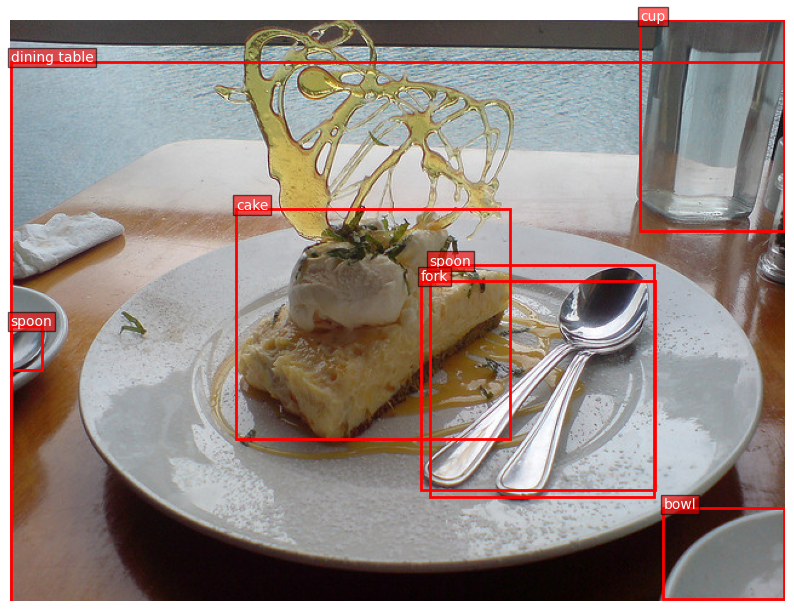

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

# Load a pretrained Mask R-CNN model trained on COCO
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
model.eval()

# COCO class labels from TorchVision

weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
COCO_CLASSES = weights.meta["categories"]

folder = "C:\Kenric\AA\course-material-2526\data\coco//val2017//val2017"

# List all files and filter image extensions
images = [f for f in os.listdir(folder) if f.lower().endswith((".jpg", ".png", ".jpeg"))]

# Pick one at random
random_image = random.choice(images)

# Full path if needed
image_path = os.path.join(folder, random_image)
image = Image.open(image_path).convert("RGB")

transform = transforms.Compose([
    transforms.ToTensor()
])

input_tensor = transform(image)
with torch.no_grad():
    prediction = model([input_tensor])[0]

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")

scores = prediction["scores"]
threshold = 0.7

for idx, score in enumerate(scores):
    if score < threshold:
        continue

    mask = prediction["masks"][idx, 0].mul(255).byte().cpu().numpy()
    box = prediction["boxes"][idx].cpu().numpy().astype(int)

    label_id = prediction["labels"][idx].item()
    label = COCO_CLASSES[label_id]

    # Create a red mask layer
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    colored_mask[:, :, 0] = 255  # red

    # Build 2D alpha: same HxW as mask → avoids shape errors
    alpha = (mask >= 128).astype(float) * 0.5

    # Draw the transparent mask
    plt.imshow(colored_mask, alpha=alpha)

    # Draw label & bounding box
    plt.text(box[0], box[1], label, color="white", fontsize=10,
             bbox=dict(facecolor="red", alpha=0.6, pad=2))

    plt.gca().add_patch(plt.Rectangle(
        (box[0], box[1]),
        box[2] - box[0],
        box[3] - box[1],
        fill=False, edgecolor="red", linewidth=2
    ))

plt.show()

### Additional exercise

Try to also denote the probability next to the classification label.

### COCO Object Detection Exercise (Faster R-CNN)

This exercise focuses on building a complete object detection pipeline using the COCO dataset, which contains real-world images annotated with multiple objects and their corresponding bounding boxes. The objective is to fine-tune a pretrained Faster R-CNN model to detect objects in these images, visualize the predictions, and save the results. The workflow begins by loading the COCO dataset manually and wrapping it in a PyTorch DataLoader to efficiently handle batching and iteration during training. To make the process manageable in a classroom or lab setting, only a subset of the dataset is used, allowing faster experimentation and reduced GPU memory requirements.

COCO annotations provide bounding boxes in the format [x, y, width, height]. However, PyTorch’s detection models expect bounding boxes in the format [xmin, ymin, xmax, ymax]. Converting between these formats is an essential preprocessing step because the model requires precise corner coordinates and associated class labels for each object in an image. Once the dataset is correctly prepared, a pretrained Faster R-CNN model is loaded. The optimizer is then configured to update the model’s parameters. In many cases, the backbone network is frozen to reduce computation and limit overfitting, while the detection head remains trainable to adapt the model to the task.

During training, the model operates in training mode, which enables gradient computation and weight updates through backpropagation. Faster R-CNN produces multiple loss components, including classification loss for predicting object categories and bounding box regression loss for refining object locations. These losses are combined and minimized during optimization. Monitoring the training loss across epochs provides insight into convergence and overall learning behavior.

After training, the model is switched to evaluation mode to perform inference on validation images. For each image, the model outputs predicted bounding boxes, class labels, and confidence scores. Bounding boxes with sufficiently high confidence are drawn on the image using visualization tools such as matplotlib. Saving these annotated images provides immediate visual confirmation of the model’s performance and demonstrates how detection systems operate in practical scenarios.

Overall, this exercise illustrates the full lifecycle of an object detection task: data preparation, annotation conversion, model fine-tuning, training, evaluation, and visualization. It emphasizes not only the mechanics of detection in PyTorch but also practical considerations such as working with large datasets, handling annotation formats correctly, and producing interpretable outputs. The result is a realistic, end-to-end object detection system that reflects how modern computer vision applications are built and evaluated.


In [ ]:
import torch
import torchvision
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Subset
import os
#pip install pycocotools

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# COCO Dataset
# -----------------------------
class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, root, annFile):
        self.dataset = CocoDetection(
            root=root,
            annFile=annFile
        )

    def __getitem__(self, idx):
        img, targets = self.dataset[idx]
        img = F.to_tensor(img)

        boxes = []
        labels = []

        for t in targets:
            x, y, w, h = t["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(t["category_id"])

        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
        }

        return img, target

    def __len__(self):
        return len(self.dataset)


def collate_fn(batch):
    return tuple(zip(*batch))


# -----------------------------
# Update these paths!
# -----------------------------
train_root = "C:\Kenric\AA\course-material-2526\data\coco//train2017//train2017"
train_ann  = "C:\Kenric\AA\course-material-2526\data\coco//annotations//instances_train2017.json"

val_root = "C:\Kenric\AA\course-material-2526\data\coco//val2017//val2017"
val_ann  = "C:\Kenric\AA\course-material-2526\data\coco//annotations//instances_val2017.json"

train_dataset = CocoDataset(train_root, train_ann)
val_dataset   = CocoDataset(val_root, val_ann)

# Optional: Use small subset 
train_dataset = Subset(train_dataset, range(2000))
val_dataset   = Subset(val_dataset, range(500))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=4, collate_fn=collate_fn)

# -----------------------------
# Pretrained Faster R-CNN
# -----------------------------
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights="DEFAULT"
)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


loading annotations into memory...
Done (t=15.79s)
creating index...
index created!
loading annotations into memory...
Done (t=0.33s)
creating index...
index created!


In [ ]:
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0

    for images, targets in loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    return total_loss / len(loader)


def evaluate(model, loader, threshold=0.5):
    model.eval()
    total_detections = 0

    with torch.no_grad():
        for images, _ in loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for output in outputs:
                scores = output["scores"]
                total_detections += (scores > threshold).sum().item()

    return total_detections


# -----------------------------
# Training Loop
# -----------------------------
num_epochs = 2

for epoch in range(num_epochs):
    loss = train_one_epoch(model, train_loader)
    detections = evaluate(model, val_loader)

    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {loss:.4f}")
    print(f"Detections above threshold: {detections}")

torch.save(model.state_dict(), "fasterrcnn_coco_finetuned.pth")


KeyboardInterrupt: 

In [ ]:
from PIL import Image, ImageDraw

model.eval()

# Take one validation image
img, _ = val_dataset[0]
input_img = img.to(device)

with torch.no_grad():
    prediction = model([input_img])[0]

# Convert tensor back to PIL image
img_np = img.permute(1, 2, 0).cpu().numpy()
img_pil = Image.fromarray((img_np * 255).astype("uint8"))

draw = ImageDraw.Draw(img_pil)

for box, score in zip(prediction["boxes"], prediction["scores"]):
    if score > 0.7:
        draw.rectangle(box.tolist(), outline="red", width=3)

img_pil.save("coco_detection_result.jpg")
print("Saved coco_detection_result.jpg")


Saved coco_detection_result.jpg


### Additional Exercise

Try to train this model and finetune it by changing parameters.

## Extra Exercise

Look up a (ANOTATED) dataset where you also need to categorize images and apply one of the models above and evaluate it.
Without anotation, you cannot evaluate properly.